- PostgreSQL에서는 체크포인터(백그라운드) 프로세스가 체크포인트를 수행.

**다음 중 하나가 발생하면 시작됨.**

1. 이전 체크포인트에서 checkpoint_timeout 에 설정된 간격 시간이 경과(기본 간격은 300초).

2. 9.4 이하 버전에서는 checkpoint_segments 에 설정된 WAL 세그먼트 파일 개수가 이전 체크포인트 이후 소모(기본 개수는 3개).

3. 버전 9.5 이상에서는 pg_wal(버전 9.6 이하에서는 pg_xlog) 디렉토리에 있는 WAL 세그먼트 파일의 전체 크기가 max_wal_size 매개변수 값 (기본값은 1GB(64개 파일))을 초과.

4. PostgreSQL 서버는 스마트 또는 고속 모드에서 중지.

5. 수퍼유저는 CHECKPOINT 명령을 수동으로 실행.

**Info**
- 버전 9.1 이하에서는 섹션 8.6 에서 언급한 대로 백그라운드 기록기 프로세스가 체크핀팅과 더티 페이지 쓰기를 모두 수행.

- 다음 하위 섹션에서는 체크포인트의 개요와 현재 체크포인트의 메타데이터를 보유하는 pg_control 파일에 대해 설명.

# **Outline of the Checkpoint Processing**

- 체크포인트 프로세스에는 데이터베이스 복구 준비와 공유 버퍼 풀의 더티 페이지 정리라는 두 가지 측면이 있음.
- 이 하위 섹션에서는 전자 측면에 초점을 맞추고 내부 처리에 대해 설명

**Internal processing of PostgreSQL Checkpoint.**

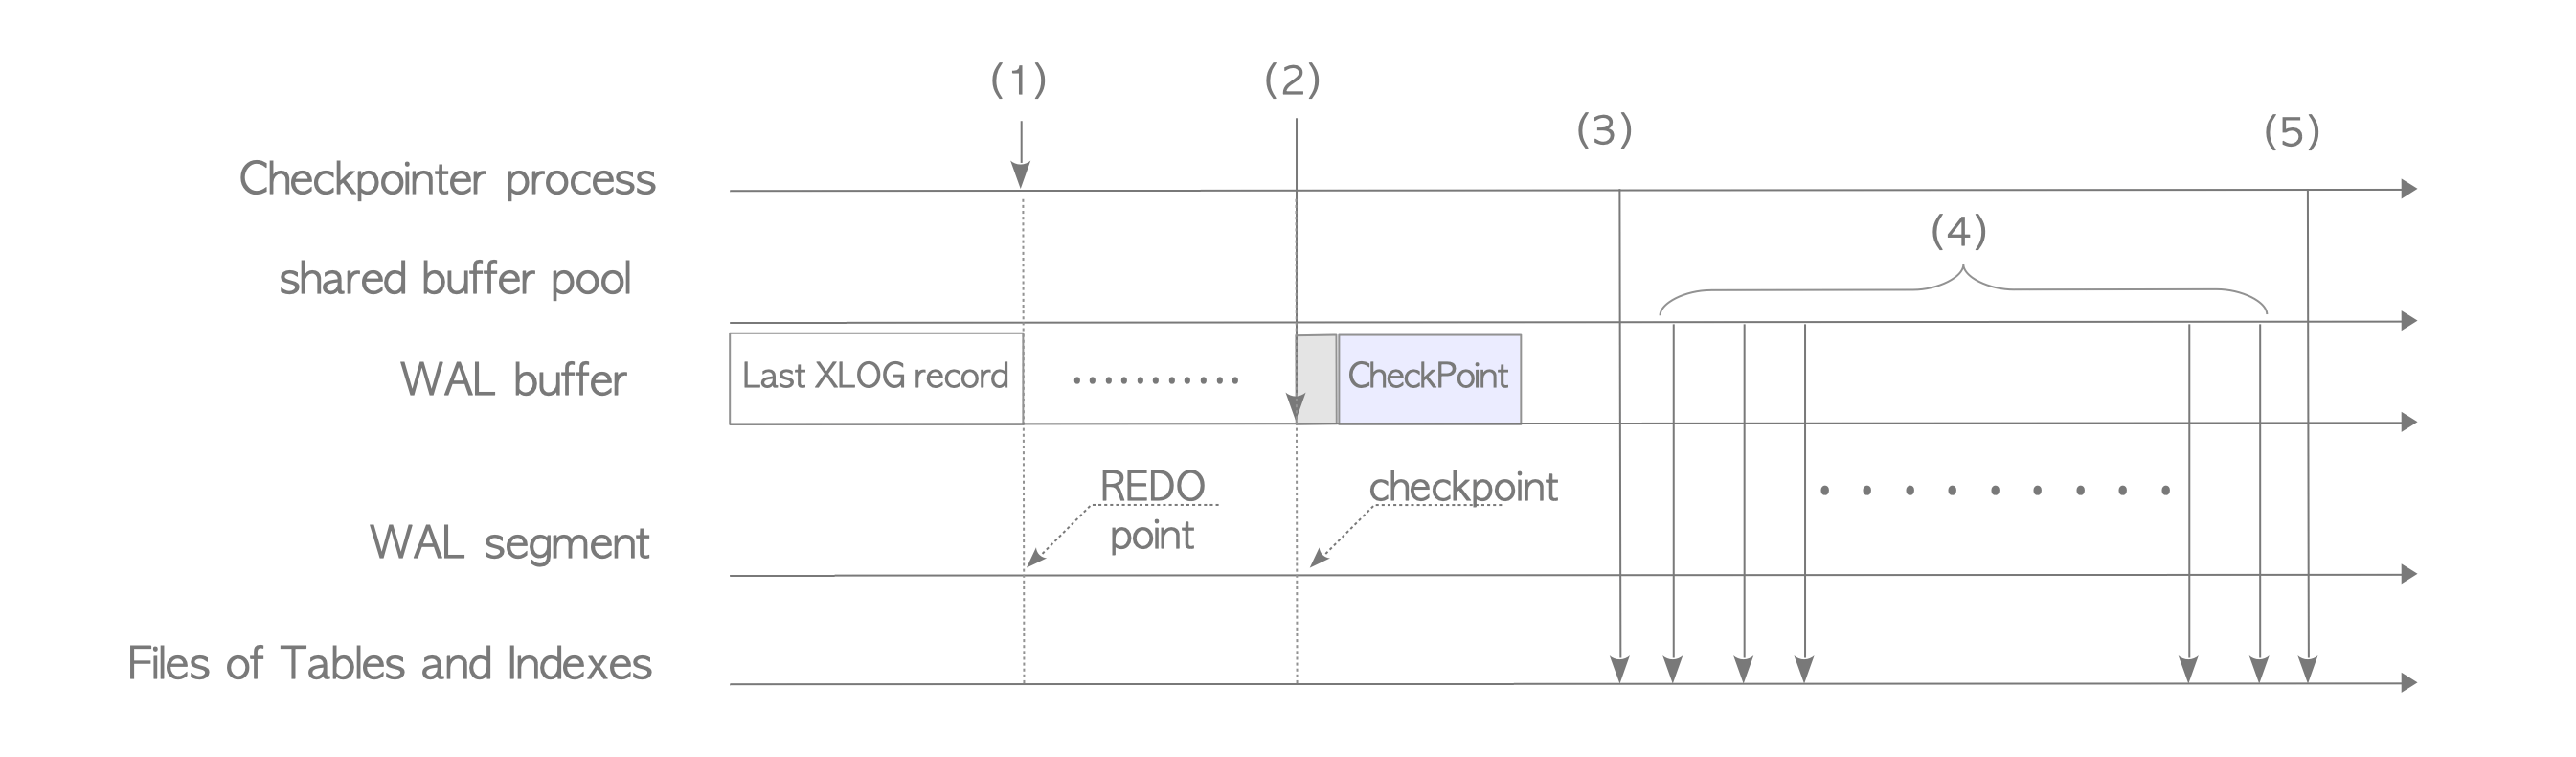

1. 체크포인트 프로세스가 시작되면 REDO 포인트가 메모리에 저장됨.
  - REDO 포인트는 최근 체크포인트가 시작된 순간에 기록된 XLOG 레코드의 위치입니다. 데이터베이스 복구의 시작점.

2. 이 체크포인트의 XLOG 레코드(즉, 체크포인트 레코드)가 WAL 버퍼에 기록됨.
  - 레코드의 데이터 부분은 다음에 의해 정의됨.
  - CheckPoint(1) 단계에서 저장된 REDO 포인트와 같은 여러 변수를 포함하는 구조.
  - 체크포인트 레코드가 기록되는 위치를 체크 포인트 라고도 함.

3. 공유 메모리의 모든 데이터(예: clog 의 내용 등)가 저장소로 플러시됨.

4. 공유 버퍼 풀의 모든 더티 페이지는 점차적으로 스토리지에 기록되고 플러시됨.

5. pg_control 파일이 업데이트됨. 이 파일에는 체크포인트 레코드가 작성된 위치(체크포인트 위치라고도 함)와 같은 기본 정보가 포함되어 있음

**struct CheckPoint**

```
typedef struct CheckPoint
{
  XLogRecPtr      redo;           /* next RecPtr available when we began to
                                   * create CheckPoint (i.e. REDO start point) */
  TimeLineID      ThisTimeLineID; /* current TLI */
  TimeLineID      PrevTimeLineID; /* previous TLI, if this record begins a new
                                   * timeline (equals ThisTimeLineID otherwise) */
  bool            fullPageWrites; /* current full_page_writes */
  uint32          nextXidEpoch;   /* higher-order bits of nextXid */
  TransactionId   nextXid;        /* next free XID */
  Oid             nextOid;        /* next free OID */
  MultiXactId     nextMulti;      /* next free MultiXactId */
  MultiXactOffset nextMultiOffset;/* next free MultiXact offset */
  TransactionId   oldestXid;      /* cluster-wide minimum datfrozenxid */
  Oid             oldestXidDB;    /* database with minimum datfrozenxid */
  MultiXactId     oldestMulti;    /* cluster-wide minimum datminmxid */
  Oid             oldestMultiDB;  /* database with minimum datminmxid */
  pg_time_t       time;           /* time stamp of checkpoint */

 /*
  * Oldest XID still running. This is only needed to initialize hot standby
  * mode from an online checkpoint, so we only bother calculating this for
  * online checkpoints and only when wal_level is hot_standby. Otherwise
  * it's set to InvalidTransactionId.
  */
  TransactionId oldestActiveXid;
} CheckPoint;
```

- 데이터베이스 복구 관점에서 위의 설명을 요약하면, 체크포인트는 REDO 포인트를 포함하는 체크포인트 레코드를 생성하고, 체크포인트 위치 및 기타 정보를 pg_control 파일에 저장.
- 이를 통해 PostgreSQL은 pg_control 파일에서 제공하는 REDO 포인트(체크포인트 레코드에서 얻은)에서 WAL 데이터를 재생하여 자체적으로 복구할 수 있음

# **pg_control File**

- pg_control 파일에는 체크포인트의 기본 정보가 포함되어 있어 데이터베이스 복구에 필수적.
  - 손상되었거나 읽을 수 없는 경우 시작점을 얻을 수 없기 때문에 복구 프로세스를 시작할 수 없음.

**pg_control 파일은 40개 이상의 항목을 저장하지만 다음 섹션에서 필요한 세 가지 항목**

**State**  
- 최신 체크포인트가 시작된 당시의 데이터베이스 서버 상태. 총 7개의 상태가 있음.

  - 'start up'은 시스템이 시작되는 상태.
  - 'shut down'은 shutdown 명령에 의해 시스템이 정상적으로 다운되는 상태를 말함.
  - ‘in production’은 시스템이 실행 중인 상태. 등등.

**Latest checkpoint location**
- 최신 체크포인트 레코드의 LSN 위치.

**Prior checkpoint location**
- 이전 체크포인트 레코드의 LSN 위치.
- 버전 11에서는 더 이상 사용되지 않음


- pg_control 파일은 기본 디렉터리 아래의 전역 하위 디렉터리에 저장됨.
- 그 내용은 pg_controldata 유틸리티를 사용하여 표시할 수 있음.


```
postgres> pg_controldata  /usr/local/pgsql/data
pg_control version number:            1300
Catalog version number:               202306141
Database system identifier:           7250496631638317596
Database cluster state:               in production
pg_control last modified:             Mon Jan 1 15:16:38 2024
Latest checkpoint location:           0/16AF0090
Latest checkpoint's REDO location:    0/16AF0090
Latest checkpoint's REDO WAL file:    000000010000000000000016

... snip ...
```

<BR>


**Removal of prior checkpoint in PostgreSQL 11**

- PostgreSQL 11 이상은 최신 체크포인트 이상을 포함하는 WAL 세그먼트만 저장.
- 이전 체크포인트가 포함된 이전 세그먼트 파일은 pg_wal 하위 디렉터리에 WAL 세그먼트 파일을 저장하는 데 사용되는 디스크 공간을 줄이기 위해 저장되지 않음